# 1. Import and path configuration part

In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from PIL import Image,ImageFile
import copy
import matplotlib.pyplot as plt
import random
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, Activation
from keras import Sequential
from keras.metrics import CategoricalCrossentropy, Accuracy

ImageFile.LOAD_TRUNCATED_IMAGES = True



In [2]:
from sam_utils import *
from models import *
from utils import *

IndentationError: expected an indented block (utils.py, line 96)

In [ ]:
datapath = "../data/msdi/"
os.chdir(datapath)

In [ ]:
!ls

# 2. Load the data references



In [ ]:
msdi = get_msdi_dataframe("") # all the references of our data

In [ ]:
msdi.head(2)

# 3. Image subsampling comparison

In [ ]:
# compare our 3 sampling methods for multiple images (see utils.py file for more details)
raw_data = {}
naive_sampling_data = {}
average_sampling_data = {}
clean_sampling_data = {}
key_list = []
n=10

for k in [random.randint(0, len(msdi)-1) for i in range(3)]: # shuffle to get another set of image
    #array = data.get(k)
    array = load_img(entry = msdi.iloc[k], msdi_path="")
    raw_data[k] = array
    naive_sampling_data[k] = naive_sampling(array, n)
    average_sampling_data[k] = average_sampling(array, n)
    clean_sampling_data[k] = clean_sampling(array, n)

    key_list.append(k)

fig, axes = plt.subplots(len(key_list), 4, figsize=(15,15))

for i in range(len(key_list)):
    k = key_list[i]
    axes[i][0].imshow(raw_data[k]) # raw image
    axes[i][1].imshow(naive_sampling_data[k]) # naively sampled image
    axes[i][2].imshow(average_sampling_data[k]) # averagesampled image
    axes[i][3].imshow(clean_sampling_data[k]) # cleanly sampled image

# we see that the naive sampling has a high variance. Some small elements can constiture 1 element of the picture, and thus lead to a lot of dropped information.
# Average sampling helps more to distinguish part of the images, and averages the colors in each portion of the image.
# Average sampling and clean sampling methods are quite equivalent in term of results (but still clean sampling is better in term of details)

# 4. HOG feature comparison

In [ ]:
# compare our the hog features for different parameters
hog4 = {}
hog8 = {}
hog16 = {}
raw_img = {}
key_list = []

for k in [random.randint(0, len(msdi)-1) for i in range(3)]: # shuffle to get another set of image
    array = load_img(entry = msdi.iloc[k], msdi_path="")
    raw_img[k] = array
    hog4[k] = compute_hog(array, 4)
    hog8[k] = compute_hog(array, 8)
    hog16[k] = compute_hog(array, 16)
    key_list.append(k)

fig, axes = plt.subplots(len(key_list), 4, figsize=(20,20))

for i in range(len(key_list)):
    k = key_list[i]
    axes[i][0].imshow(raw_img[k]) # raw image
    axes[i][1].imshow(hog16[k]) # 16 hog image
    axes[i][2].imshow(hog8[k]) # 8 hog image
    axes[i][3].imshow(hog4[k]) # 4 hog image

# with hog=4 we loose a lot of information (the geometric aspect of the image is a bit lost in non rectangular areas), but not so much from switching from 8 to 16. It would be interesting to see the impact on the prediction results.

# 5. Image classifier

## 1. Data formatting

In [ ]:
labels = msdi.genre.values
ref = msdi.msd_track_id.values
data = msdi.iloc[:1000].apply(preprocess_image_vectorized, axis=1)
labels = labels[:1000]
ref = ref[:1000]

In [ ]:
print(len(Counter(labels)), Counter(labels)) # number of labels & repartition of the labels

In [ ]:
X = np.array(list(data.values))

In [ ]:
Y, classes, y_dict = one_hot_encode(labels)

In [ ]:
print(X.shape,Y.shape)

In [225]:
#normalize our data (X will take its values in [0,1] interval)

normalize = False

if normalize:
    X = X.astype(np.float16) # cast to signed int

    for i in range(X.shape[0]):
        X[i] = X[i]/255
        if i in [10,100,1000,10000]:
            print(i)

## 2. Simplistic model : 3x3 array, logistic regression

In [228]:
clf = SGDClassifier()

In [252]:
#train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(len(X),-1), classes, test_size=0.2)

# train classifier
clf.fit(X_train, Y_train)

SGDClassifier()

In [253]:
#predict on the test set
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_pred, Y_test))

0.25


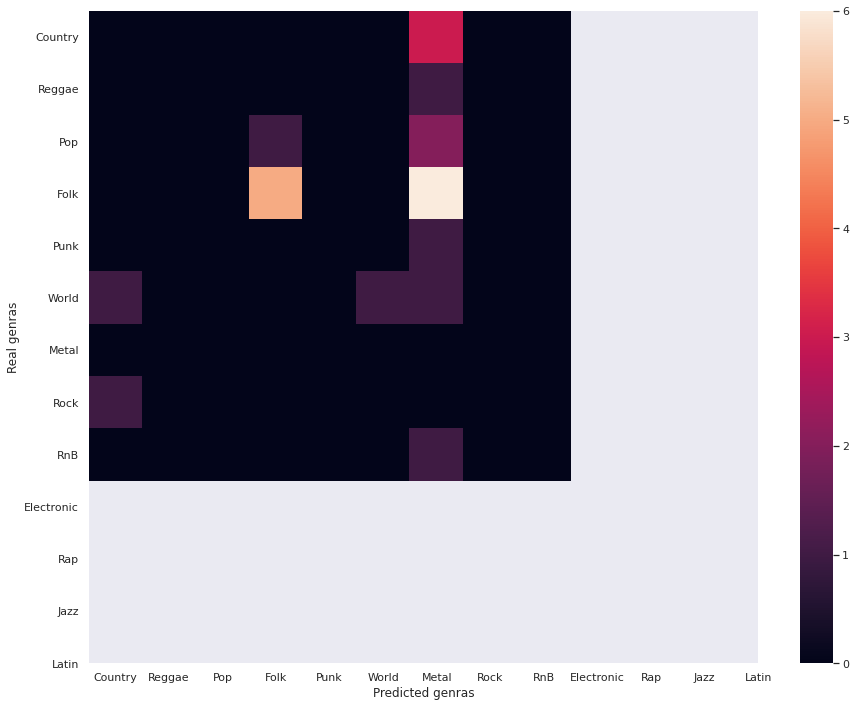

In [254]:
# plot the confusion matrix
plot_confusion(Y_test,Y_pred, y_dict)

# We see that the most predicted labels by the classifier are 'electronic' and 'world'. Other labels are not so often predicted

In [255]:
keep = list(y_dict.keys())
keep.remove("Rock")
keep.remove("Electronic")
plot_confusion(Y_test,Y_pred, y_dict, keep)

#we see that, appart from our 2 most present classes (Rock and Electronic), our images get classified very randomly
# The confusion matrix of the ideal classifier should be a diagonal matrix, and the confusion matrix we get by removing "Rock" and "Electronic" genras are far from this ideal

IndexError: index 10 is out of bounds for axis 0 with size 9

## 3. CNN

In [12]:
#Use raw data as input of CNN

# Train/Test split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
del X # useful since X_train and X_test take additionnal space (which is valuable for the fitting of our model)


In [13]:
X_train.shape

(13430, 200, 200, 3)

In [14]:
class_weight = compute_class_weight(classes)
print(class_weight)
weight_tensor = convert_to_tensor(list(class_weight.values()))

{0: 3.982419855222337, 1: 2.869597615499255, 2: 9.08254716981132, 3: 1.0, 4: 4.783850931677019, 5: 3.3428819444444446, 6: 1.51138147566719, 7: 2.0593582887700537, 8: 4.645355850422195, 9: 3.108151735270379, 10: 9.749367088607595, 11: 13.656028368794326, 12: 10.054830287206265, 13: 7.014571948998178, 14: 25.335526315789473}


In [87]:
model = image_model()

<function models.image_model()>

In [100]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 196, 196, 30)      2280      
_________________________________________________________________
activation_42 (Activation)   (None, 196, 196, 30)      0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 196, 196, 30)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 193, 193, 20)      9620      
_________________________________________________________________
activation_43 (Activation)   (None, 193, 193, 20)      0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 193, 193, 20)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 191, 191, 15)    

In [101]:
model.fit(X_train, Y_train, epochs=10) #train our CNN

Epoch 1/10
420/420 [==============================] - 40s 80ms/step - loss: 2.7617 - accuracy: 0.8727
Epoch 2/10
420/420 [==============================] - 34s 80ms/step - loss: 2.6651 - accuracy: 0.8867
Epoch 3/10
420/420 [==============================] - 34s 81ms/step - loss: 2.6653 - accuracy: 0.8868
Epoch 4/10
420/420 [==============================] - 34s 81ms/step - loss: 2.6637 - accuracy: 0.8870
Epoch 5/10
420/420 [==============================] - 34s 81ms/step - loss: 2.6624 - accuracy: 0.8872
Epoch 6/10
420/420 [==============================] - 34s 81ms/step - loss: 2.6688 - accuracy: 0.8864
Epoch 7/10
420/420 [==============================] - 34s 82ms/step - loss: 2.6685 - accuracy: 0.8864
Epoch 8/10
420/420 [==============================] - 34s 82ms/step - loss: 2.6634 - accuracy: 0.8871
Epoch 9/10
420/420 [==============================] - 34s 81ms/step - loss: 2.6702 - accuracy: 0.8862
Epoch 10/10
420/420 [==============================] - 34s 81ms/step - loss: 2.666

In [102]:
Y_pred = model.predict(X_test) #predict on new data
Y_pred = np.array([np.argmax(elem) for elem in Y_pred])

In [103]:
Y_real = Y_test.reshape(3358,15)
Y_real = np.array([np.argmax(elem) for elem in Y_real])

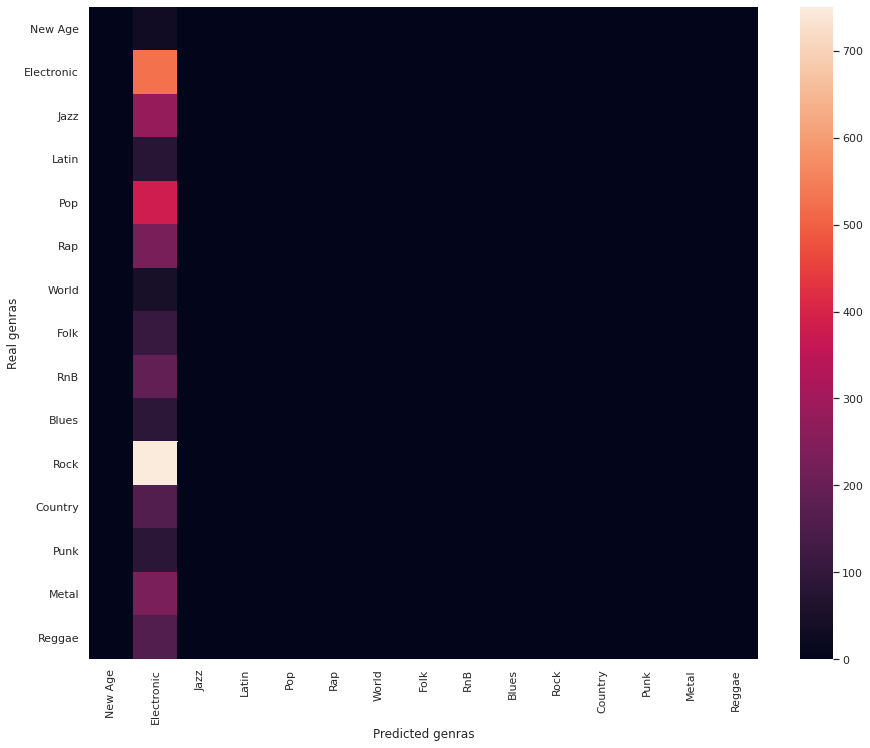

In [104]:
plot_confusion(Y_real, Y_pred, y_dict)

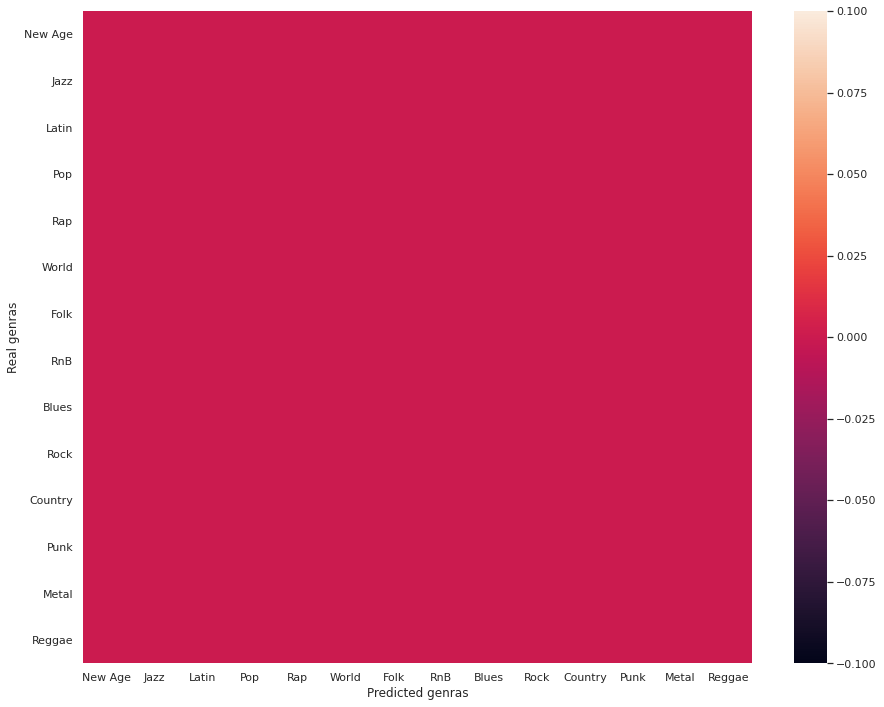

In [106]:
keep = list(y_dict.keys())
#keep.remove("Rock")
keep.remove("Electronic")
plot_confusion(Y_real,Y_pred, y_dict, keep)